In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import os

### data + util functions

In [2]:
def perturb(x_vals, x_min, x_max, sig=0.03):
    """
    Stochastic perturbation of x_vals. Logic copied from paper code, just refactored a bit. 
    Returns perturbed x_vals.

    Inputs:
    x_vals: domain of all x values
    x_min: minimum x value
    x_max: maximum x value
    sig: factor used in noise calculation
    """

    # add noise to x_vals
    dx = x_vals[1] - x_vals[0]  
    noise = dx * torch.randn_like(x_vals) * sig
    x = x_vals + noise
    
    # if perturbed vals fall outside of x_vals domain, move them back in
    x.data[x < x_min] = x_min - x.data[x < x_min]  
    x.data[x > x_max] = 2 * x_max - x.data[x > x_max]  

    # ensure minimum and maximum x vals are first and last elements still
    x.data[0] = torch.ones(1, 1) * x_min
    x.data[-1] = torch.ones(1, 1) * x_max

    return x

def gen_approx_x_domain(x_min, x_max, dx, device, requires_grad=True):
    """
    Generate x values from x_min+dx to x_max-dx in steps of size dx. Returns tensor of shape (*, 1).

    Inputs:
    x_min: minimum x value
    x_max: maximum x value
    dx: x step size
    device: torch device
    """

    return torch.tensor(np.arange(x_min, x_max, dx).reshape(-1, 1), requires_grad=requires_grad).to(device)

### loss class definition

In [3]:
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss, self).__init__()
        self.loss = None

        # NOTE if you change loss terms returned, must change this and return+calculations in calc_loss()
        self.return_names = ["loss_ovr", "loss_f", "u_trivial_penalty"]
    
    def MSE_f(self, f_pred):
        """
        Returns MSE loss on f predictions. 

        Inputs:
        f_pred: batch of differential equation predictions
        """

        return torch.mean(f_pred**2)

    def calc_u_trivial_penalty(self, u_pred):
        """
        Returns a term that penalizes trivial solutions.

        Inputs:
        u_pred: batch of wavefunction predictions
        """

        return 1 / torch.mean(u_pred**2 + 1e-6)

    def calc_loss(self, u_pred, f_pred):
        """
        Calculate loss terms for predictions. Returns a tuple of losses. 
        Names and order of returned terms should match self.return_names.

        Inputs:
        u_pred: batch of wavefunction predictions 
        f_pred: batch of differential equation predictions
        """

        # differential equation MSE loss
        loss_f = self.MSE_f(f_pred)

        # trivial solution penalty 
        u_trivial_penalty = self.calc_u_trivial_penalty(u_pred)

        # overall loss
        loss_ovr = loss_f + u_trivial_penalty 

        return loss_ovr, loss_f, u_trivial_penalty

### PINN class definition

In [4]:
class SinActivation(torch.nn.Module):
    @staticmethod
    def forward(input):
        """
        Passes input tensor through sin function. Used in neural network class.

        Inputs:
        input: tensor batch of layer outputs
        """

        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self, input_size, device, x_min=0., x_max=1., init_E=1, use_unitless_const=False, optimizer_lr=0.0001, optimizer_betas=(0.999, 0.9999)):
        super(PINN, self).__init__()

        # constants
        if use_unitless_const:
            self.planck_term_constant = 1  # unitless 
        else:
            self.planck_term_constant = 0.2378  # hbar**2/2*m in units eV^2*s^2*kg^-1

        # torch device
        self.device = device

        # set x minimum and maximum (this is more a property of the data, but it may as well be a property of the network)
        self.x_min = x_min
        self.x_max = x_max

        # E initialization
        self.E = torch.tensor(init_E, dtype=torch.double).to(device)

        # network
        self.activation = SinActivation()
        self.dense0 = nn.Linear(input_size + 1, 64, dtype=torch.double)  # NOTE +1 to input size for implicit E prediction
        self.dense1 = nn.Linear(64, 64, dtype=torch.double)
        self.dense_out = nn.Linear(64, 1, dtype=torch.double)

        # optimizer + loss
        self.optimizer = optim.Adam(self.parameters(), lr=optimizer_lr, betas=optimizer_betas)
        self.loss_criteria = PINNLoss()
        self.loss = None

    def forward_net(self, data):
        """
        Simple forward pass through full network. Returns network output.

        Inputs:
        data: tensor with correct input shape
        """

        out = self.dense0(data)
        out = self.activation(out)
        out = self.dense1(out)
        out = self.activation(out)
        out = self.dense_out(out)
        
        return out

    def scale_output(self, x, output):
        """
        Parametric scaling function to apply to network output as described in paper.

        Inputs:
        x: x values used to generate output
        output: network output
        """

        scale = (1 - torch.exp(-(x - self.x_min))) * (1 - torch.exp((x - self.x_max)))

        return output * scale

    def forward(self, x):
        """
        Forward pass on x. Combines current E with x. 
        Returns output prediction u and evaluated differential equation value f.

        Inputs:
        x: x data
        """

        # create E input vector
        E_batch = torch.tensor([[self.E]] * x.shape[0]).to(self.device)
        
        # combine E with x
        nn_inp = torch.cat([x, E_batch], dim=1)

        # pass through nn
        u = self.forward_net(nn_inp)

        # scale output 
        u = self.scale_output(x, u)

        # calc gradients
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        
        # differential equation
        f = self.planck_term_constant * u_xx + self.E * u
        
        return u, f

    def forward_inference(self, x):
        """
        Inference forward pass on x. Combines current E with x. Used outside of training.
        Returns output prediction u.

        Inputs:
        x: x data
        """

        # create E input vector
        E_batch = torch.tensor([[self.E]] * x.shape[0]).to(self.device)
        
        # combine E with x
        nn_inp = torch.cat([x, E_batch], dim=1)

        # pass through nn
        u = self.forward_net(nn_inp)

        # scale output 
        u = self.scale_output(x, u)

        return u

    def backward(self, u_pred, f_pred):
        """
        Network backward pass. Returns tuple of loss values.
        
        Inputs:
        u_pred: batch of wavefunction predictions 
        f_pred: batch of differential equation predictions
        """

        # calculate losses
        losses = self.loss_criteria.calc_loss(u_pred, f_pred)
        self.loss = losses[0]  # NOTE overall loss should always be first value returned in losses tuple

        # backprop + update params
        self.loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return losses 

### generate data

In [5]:
# set gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# generate x from 0 to 1
x_min = 0.
x_max = 1.
train_dx = 0.01
train_perturb_sig = 0.03
dx = 0.001
x_train = gen_approx_x_domain(x_min, x_max, train_dx, device, requires_grad=True)  # x data for training
x_test = gen_approx_x_domain(x_min, x_max, dx, device, requires_grad=False)  # x data for inference

# rm + create directory to save best models across training to
clear_prev_temp_models = True
temp_model_dir = "inf_sq_well_E_scan_saved_models"
if clear_prev_temp_models:
    os.system(f"rm -rf {temp_model_dir}")
    os.system(f"mkdir {temp_model_dir}")

In [6]:
x_train.shape

torch.Size([100, 1])

### plot functions

In [ ]:
def display_plot(x_vals, y_vals, x_label="x", y_label="y", line_color="b", log_scale=False, data_label=None, title=None):
    """
    Generate plot for x_vals and y_vals.

    Inputs:
    pretty self-explanatory
    """

    if data_label:
        plt.plot(x_vals, y_vals, color=line_color, label=data_label)
        plt.legend()
    else:
        plt.plot(x_vals, y_vals, color=line_color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    if log_scale:
        plt.yscale("log")

    plt.show()

def display_multi_y_plot(x_vals, y0_vals, y1_vals, label0="label0", label1="label1", color0="b", color1="r", x_label="x", y_label="y", log_scale=False):
    """
    Generate matplot line chart for x_vals and two response variables y0_vals and y1_vals.
    (i.e. prediction vs. analytical plot)

    Inputs:
    pretty self-explanatory
    """

    plt.plot(x_vals, y0_vals, label=label0, color=color0)
    plt.plot(x_vals, y1_vals, label=label1, color=color1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if log_scale:
        plt.yscale("log")

    plt.legend()
    plt.show()

def save_progress_plot(output_dir, x, preds, E_history, analytical_E_vals, analytical_u, loss_history, 
                       overlay_analytical=False, analytical_n=None, corrected_preds=None):
    """
    Saves subplot figures across training. Images are later used to construct a video. Returns path to created image.

    Inputs:
    output_dir: directory where figures are saved
    x: flattened np array of approximate domain of x values (should be same every call)
    preds: flattened np array of predictions for x
    E_history: list of E values at every training step
    analytical_E_vals: list of analytical E values
    analytical_u: flattened np array of analytical u values for x
    loss_history: list of DE loss values for every training step
    overlay_analytical: set to True to plot analytical solution with predictions
    analytical_n: energy eigenvalue of current expected analytical solution
    corrected_preds: flattened np array of normalized + sign-corrected predictions
    """

    epoch_list = [i for i, _ in enumerate(E_history)]

    # subplot mosaic layout
    fig, axes = plt.subplot_mosaic(
        [
            ["left", "top_right"],
            ["left", "bottom_right"]
        ],
        layout="constrained",  
        figsize=(10, 6)
    )

    
    # left: predicted wavefunction and analytical conditionally
    axes["left"].set_xlabel("x")

    if (overlay_analytical):
        axes["left"].plot(x, preds, label="prediction", color="b")
        if (corrected_preds is not None):
            axes["left"].plot(x, corrected_preds, "g--", label="sign corrected normalized prediction")
        axes["left"].plot(x, analytical_u, label=f"analytical n={analytical_n}", color="r")
        axes["left"].set_ylabel("u")
        axes["left"].legend()
        axes["left"].set_ylim(-3, 3)  # NOTE arbitrary
    else:
        axes["left"].plot(x, preds, color="b")
        axes["left"].set_ylabel(r"$\hat{u}$")
        axes["left"].set_ylim(-5, 5)  # NOTE arbitrary

    # top right: E prediction and analytical E
    axes["top_right"].plot(epoch_list, E_history, color="b")
    reached_analytical = False
    for i, analytical_E in enumerate(analytical_E_vals):
        if (E_history[-1] >= analytical_E):
            reached_analytical = True
            axes["top_right"].plot(epoch_list, [analytical_E for _ in epoch_list], label=f"E_{i + 1}")
    if reached_analytical: 
        axes["top_right"].legend()
    axes["top_right"].set_xlabel("epoch")
    axes["top_right"].set_ylabel("E")

    # bottom right: DE loss
    axes["bottom_right"].plot(epoch_list, loss_history, color="b")
    axes["bottom_right"].set_xlabel("epoch")
    axes["bottom_right"].set_ylabel("Schrodinger loss")
    axes["bottom_right"].set_yscale("log")

    # save plot to file
    savefig_base_name = "plot"
    output_file_name = f"{output_dir}/{savefig_base_name}_{epoch_list[-1]}.png" 
    fig.savefig(output_file_name)
    plt.close(fig)

    return output_file_name

### analytical solution functions

In [7]:
def calc_analytical(x_vals, well_width, n):
    """
    Returns np array of analytical solution for each value in x_vals of infinite 
    square well in 1D and its corresponding energy eigenvalue.

    Inputs:
    x_vals: x values across the domain of x 
    well_width: width of well (if x_min=0, can just set this to x_max)
    n: energy level
    """

    hbar_sq_over_2m = 0.2378  # eV**2 * s**2 * kg**-1   
    u = np.sqrt(2 / well_width) * np.sin(n * np.pi * x_vals / well_width)
    E = n**2 * np.pi**2 * hbar_sq_over_2m / well_width**2

    return u, E

def calc_MSE(u_true, u_pred):
    """
    Calculates and returns mean squared error between u_true and u_pred.

    u_true: flattened np array of analytical u vector across approximate domain of x
    u_pred: flattened np array of predicted u vector across approximate domain of x (must be same x used to generate u_true)
    """

    return np.mean(np.sum((u_true - u_pred)**2))

def calc_orth(u_prev, u_current, dx):
    """
    Calculates and returns summation-approximation orthogonality term.

    Inputs:
    u_prev: flattened np array of sum of all previous u vectors across approximate domain of x
    u_current: flattened np array of current predicted u vector across approximate domain of x (must be same x used to generate u_true)
    dx: x step used across approximate domain of x
    """

    return np.dot(u_prev, u_current) * dx

def calc_pred_norm_const(approx_x_domain_pred_vec, dx):
    """
    Returns the prediction normalization constant based on predictions across the approximate domain of x.

    Inputs:
    approx_x_domain_pred_vec: vector of predictions u across the approximate x domain
    dx: step size across approximate x domain
    """

    return 1. / torch.sqrt(dx * torch.sum(approx_x_domain_pred_vec**2))

def compare_analytical(eigen_pinn, n, x_test, u_prev, dx, well_width):
    """
    Plots predicted solutions against analytical solutions and computes error values.
    Returns flattened np array of eigen_pinn predictions across x_test.

    Inputs:
    eigen_pinn: dictionary containing best model info (output of get_best_pinns())
    n: eigenvalue number
    x_test: x data spanning well for inference
    u_prev: flattened np array of sum of all previous u vectors across approximate domain of x
    well_width: width of well (if x_min=0, can just set this to x_max)
    """

    x_test_detach = x_test.flatten().detach().cpu().numpy()  # move tensor for convenience
    analytical_u, analytical_E = calc_analytical(x_test_detach, well_width, n)
    pred_u = (eigen_pinn["model"].forward_inference(x_test) * eigen_pinn["pred_norm_const"]).flatten().detach().cpu().numpy()

    # hacky check for negative predictions
    if (int(np.round(np.mean(analytical_u[1:] / pred_u[1:]))) == -1):
        flipped_sign = True
        pred_u = -pred_u
    else:
        flipped_sign = False

    mse = calc_MSE(analytical_u, pred_u)  # mean square error calculation on predicted wavefunction
    orth = calc_orth(u_prev, pred_u, dx)  # approximate orthogonality term

    print(f"n = {n}")
    print(f"analytical E = {analytical_E}")
    print(f"predicted E = {eigen_pinn['model'].E}")
    print(f"differential eqn loss = {eigen_pinn['losses'][1]}")
    print(f"prediction normalization constant = {eigen_pinn['pred_norm_const']}")
    print(f"flipped sign = {flipped_sign}")
    print()
    print(f"MSE = {mse}")
    print(f"orthogonal term: {orth}")
    print()
    print("predicted wavefunction:")
    display_multi_y_plot(x_test_detach,
                            pred_u,
                            analytical_u,
                            label0="predicted",
                            label1="analytical",
                            y_label="u")
    print()

    return pred_u


### train loop

In [16]:
def run_train_loop(x_train, x_min, x_max, perturb_sig, E_range, num_train_steps_per_E, save_denom, 
                   model_save_dir, loss_criteria_idx, device, print_epoch_status=True, save_models=True, 
                   save_progress_vid=False, save_progress_dir="", E_range_idx_per_n=[]):
    """
    Main train loop function. Returns best models across training windows, train loss values, and number of total epochs.

    Inputs:
    x_train: x data spanning domain of well
    x_min: minimum x
    x_max: maximum x
    perturb_sig: amount to perturb x_train values by
    E_range: list of E values to train models across
    num_train_steps_per_E: number of fwd+bwd passes with x_train to perform per value in E_range
    save_denom: save best model across the last this many epochs every this many epochs
    model_save_dir: directory to save best models to
    loss_criteria_idx: index of loss term to use for evaluating best model to save (see PINNLoss)
    device: torch device
    print_epoch_status: set to True to print updates every however many epochs
    save_models: set to True to save models to disk
    save_progress_vid: set to True to save plots after every E (used to create training progress video)
    save_progress_dir: str directory where progress plots are saved
    E_range_idx_per_n: list of number of sub E steps for each E in E_range (used for determining which analytical solution to use when save_progress_vid)
    """

    start_time = time.time()
    print(f"training network on E in [{min(E_range)}, {max(E_range)}] with {num_train_steps_per_E} training steps per E ({len(E_range) * num_train_steps_per_E} total training steps)...")
    epoch = 0  # epoch counter 

    # initialize network
    lr = 8e-3
    betas = (0.999, 0.9999)
    E_min = E_range[0]
    pinn = PINN(x_train.shape[1], device, x_min=x_min, x_max=x_max, init_E=E_min, optimizer_lr=lr, optimizer_betas=betas)
    pinn.to(device)

    epoch_print_denom = 1000  # print outputs every this many epochs
    default_min_loss = 1000  # default minimum loss (ideally model beats this after like 1 step of training)
    min_loss = default_min_loss
    current_best_epoch = -1  # init best model epoch (if saved models have this val it means no model beat default minimum loss)

    # initialize best model (copy the starting model) 
    current_best_pinn = PINN(x_train.shape[1], device, x_min=x_min, x_max=x_max, init_E=pinn.E, optimizer_lr=lr).to(device)
    current_best_pinn.load_state_dict(pinn.state_dict())
    min_save_epoch = 100  # NOTE arbitrary, seems like this is enough to not save initial trivial solution prediction

    E_predictions = []  # track E across epochs (not exactly necessary since E values are defined before training - just convenient) 
    prev_pinns = []  # list to store best models 
    train_loss_vals = []  # track losses every epoch

    # set values used for plotting analytical solution against predictions in progress plots
    if save_progress_vid:
        all_analytical_u = []
        all_analytical_E = []
        progress_plot_fi_names = []

        # NOTE always clears previous run
        os.system(f"rm -rf {save_progress_dir}")
        os.system(f"mkdir {save_progress_dir}")

        # determine expected num of solutions
        expected_analytical_solns = len(E_range_idx_per_n)
        if (expected_analytical_solns == 0): 
            expected_analytical_solns = 3
            overlay_analytical = False
        else:
            overlay_analytical = True

        # get all needed analytical solutions
        for i in range(expected_analytical_solns):
            n = i + 1
            analytical_u, analytical_E = calc_analytical(x_test.flatten().detach().cpu().numpy(), x_max, n)
            all_analytical_u.append(analytical_u)
            all_analytical_E.append(analytical_E)

    # main train loop
    # each loop trains a network using current E value for num_train_steps_per_E
    for E_idx, E_current in enumerate(E_range):
        pinn.E = E_current

        for train_step in range(num_train_steps_per_E):
            # perturb x values
            x_perturbed = perturb(x_train, x_min, x_max, sig=perturb_sig)

            # forward pass
            u_pred, f_pred = pinn.forward(x_perturbed)
            
            # backward pass
            losses = pinn.backward(u_pred, f_pred)
            train_loss_vals.append([loss_val.item() for loss_val in losses])
            
            # track E
            E_predictions.append(E_current)

            # check if new minimum overall loss attained across this window of epochs
            if (epoch >= min_save_epoch) and (losses[loss_criteria_idx] < min_loss):
                # update current best loss and epoch
                min_loss = losses[loss_criteria_idx]
                current_best_epoch = epoch
                
                # copy current model state 
                current_best_pinn = PINN(x_train.shape[1], device, x_min=x_min, x_max=x_max, init_E=pinn.E, optimizer_lr=lr, optimizer_betas=betas).to(device)
                current_best_pinn.load_state_dict(pinn.state_dict())

            # save the best (min ovr loss) model across this window of epochs
            if (epoch >= min_save_epoch) and (epoch % save_denom == 0):
                min_loss = default_min_loss  # reset min loss to default (ideally next best model beats quickly) 

                if save_models: 
                    torch.save(current_best_pinn, f"{model_save_dir}/epoch_{current_best_epoch}.pt")  # save model to file

                # copy current model state and save (model, epoch) tuple to list
                pinn_copy = PINN(x_train.shape[1], device, x_min=x_min, x_max=x_max, init_E=current_best_pinn.E, optimizer_lr=lr, optimizer_betas=betas).to(device)
                pinn_copy.load_state_dict(current_best_pinn.state_dict())
                prev_pinns.append((pinn_copy, current_best_epoch))

            # print outputs
            if (print_epoch_status) and (epoch % epoch_print_denom == 0):
                print("\n" + "=" * 20 + f" EPOCH {epoch} " + "=" * 20)
                print()
                print("train losses:")
                for return_name, val in zip(pinn.loss_criteria.return_names, train_loss_vals[epoch]):
                    print(f"{return_name} = {val:.3e}")
                print()
                print(f"current E = {pinn.E.item()}")
                print(f"elapsed model training time: {(time.time() - start_time) / 60 :.2f} minutes")

            epoch += 1  # update epoch num 
        
        # START progress plot
        # NOTE this assumes you have analytical solutions - but this is strictly for comparison, completely independent of training
        if (save_progress_vid):
            # get current predictions 
            progress_preds = current_best_pinn.forward_inference(x_test)

            # normalize predictions
            progress_pred_norm_const = calc_pred_norm_const(progress_preds, dx)
            corrected_progress_preds = (progress_preds * progress_pred_norm_const).flatten().detach().cpu().numpy()
            
            # determine current n 
            current_i_n = 0
            for i_n, idx in enumerate(E_range_idx_per_n):
                if (E_idx < idx):
                    current_i_n = i_n
                    break

            # ensure prediction has same sign as analytical (best fix I could come up with)
            if (int(np.round(np.mean(all_analytical_u[current_i_n][1:] / corrected_progress_preds[1:]))) == -1):
                corrected_progress_preds = -corrected_progress_preds

            plot_fi_name = save_progress_plot(save_progress_dir, 
                                              x_test.flatten().detach().cpu().numpy(), 
                                              progress_preds.flatten().detach().cpu().numpy(), 
                                              E_predictions,
                                              all_analytical_E,
                                              all_analytical_u[current_i_n],
                                              np.array(train_loss_vals)[:, loss_criteria_idx],
                                              overlay_analytical=overlay_analytical,
                                              analytical_n=current_i_n + 1,
                                              corrected_preds=corrected_progress_preds
                                             )

            # save file names for video construction later
            progress_plot_fi_names.append(plot_fi_name)
        # END progress plot 

    # plot losses
    epoch_list = [e for e in range(epoch)]
    for loss_idx, loss_name in enumerate(pinn.loss_criteria.return_names):
        display_plot(epoch_list,
                     torch.tensor(train_loss_vals)[:, loss_idx].detach().numpy(),
                     x_label="epoch",
                     y_label=loss_name,
                     log_scale=True)

    # plot E
    display_plot(epoch_list, E_predictions, x_label="epoch", y_label=r"$\hat{E}$")

    print(f"train time: {(time.time() - start_time) / 60 :.2f} minutes")

    # START progress video logic
    if (save_progress_vid):
        video_name = f"Emin={E_range[0]:.3f}_Emax={E_range[-1]:.3f}"
        create_video_script_name = f"create_progress_video_{video_name}.sh"

        # create text file of ordered progress plot file names for ffmpeg input
        ffmpeg_input_file = f"{video_name}_input.txt"
        with open(ffmpeg_input_file, "w") as fi:
            fi.write("\n".join([f"file {fi_name}\nduration 0.32" for fi_name in progress_plot_fi_names]))

        # idk what each argument does, but this command appears to work
        cmd = f"ffmpeg -f concat -i {ffmpeg_input_file} -r 30 -pix_fmt yuv420p {save_progress_dir}/{video_name}.mp4"

        # creates a bash script that creates a video when ran
        with open(create_video_script_name, "w") as fi:
            fi.write(cmd)
            fi.write("\n")

        # sets the bash script to executable
        os.system(f"chmod +x {create_video_script_name}")
        print(f"Created bash script {create_video_script_name} to generate progress video from plots. Run script from correct bash environment.")
    # END progress video logic

    print()

    return prev_pinns, train_loss_vals, epoch

training network on E in [1.0, 22.90000000000002] with 1000 training steps per E (220000 total training steps)...

==================== EPOCH 0 ====================

train losses:
loss_ovr = 2.465e+03
loss_f = 2.084e-03
u_trivial_penalty = 2.465e+03

current E = 1.0
elapsed model training time: 0.00 minutes


/tmp/ipykernel_9525/2910698215.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor(init_E, dtype=torch.double).to(device)



==================== EPOCH 1000 ====================

train losses:
loss_ovr = 6.162e+00
loss_f = 5.159e+00
u_trivial_penalty = 1.003e+00

current E = 1.1
elapsed model training time: 0.06 minutes

==================== EPOCH 2000 ====================

train losses:
loss_ovr = 7.652e+00
loss_f = 6.204e+00
u_trivial_penalty = 1.449e+00

current E = 1.2000000000000002
elapsed model training time: 0.11 minutes

==================== EPOCH 3000 ====================

train losses:
loss_ovr = 5.177e+00
loss_f = 3.399e+00
u_trivial_penalty = 1.779e+00

current E = 1.3000000000000003
elapsed model training time: 0.16 minutes

==================== EPOCH 4000 ====================

train losses:
loss_ovr = 4.835e+00
loss_f = 1.806e+00
u_trivial_penalty = 3.028e+00

current E = 1.4000000000000004
elapsed model training time: 0.22 minutes

==================== EPOCH 5000 ====================

train losses:
loss_ovr = 5.405e+00
loss_f = 4.194e+00
u_trivial_penalty = 1.211e+00

current E = 1.500000000

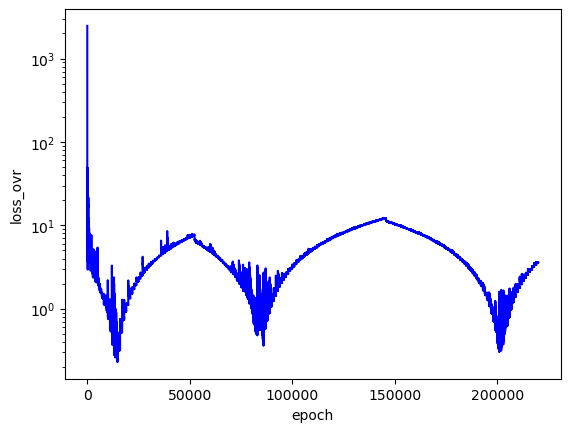

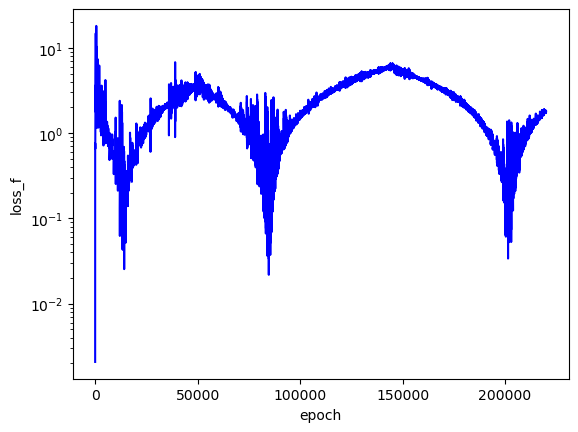

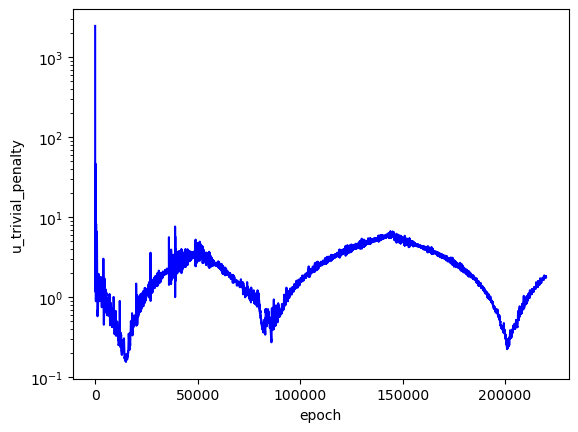

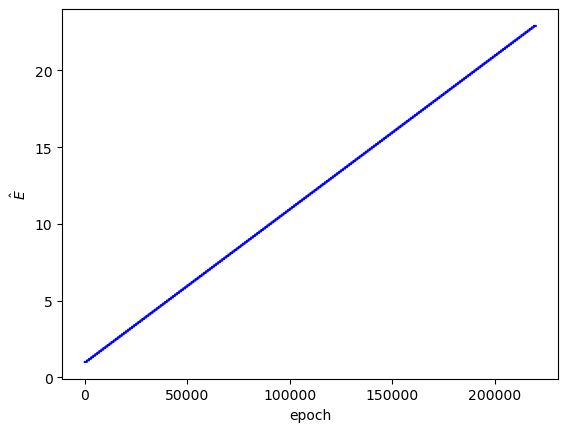

train time: 12.96 minutes
Created bash script create_progress_video_Emin=1.000_Emax=22.900.sh to generate progress video from plots. Run script from correct bash environment.



In [17]:
perturb_sig = 0.03  # amount to perturb x values by in training
E_min = 1  # starting E
E_max = 23  # ending E
E_increment = 0.1  # amount to increment E by across training 
E_range = np.arange(E_min, E_max, E_increment)  # set range of E to search over
num_train_steps_per_E = 1000  # number of fwd+bwd passes to do for each E across search
model_save_dir = temp_model_dir
loss_criteria_idx = 1  # NOTE unavoidable hardcoded index of loss value from PINNLoss to use for model judgement
save_denom = 10000

# train model(s)
prev_pinns, train_loss_vals, epoch = run_train_loop(x_train, x_min, x_max, perturb_sig, E_range, num_train_steps_per_E, 
                                                    save_denom, model_save_dir, loss_criteria_idx, device, 
                                                    save_models=False, save_progress_vid=True, save_progress_dir="scan_E_progress_plots")

### visualize all saved PINNs

In [18]:
def visualize_pinns(pinns, x_test):
    """
    Plots all models' predictions across x_test.

    Inputs:
    pinns: list of torch models
    x_test: x data spanning well for inference
    """

    for p in pinns:
        # predict across approximate x domain and plot
        pred = p[0].forward_inference(x_test)
        display_plot(x_test.flatten().detach().cpu().numpy(), 
                        pred.flatten().detach().cpu().numpy(), 
                        x_label="x", 
                        y_label=r"$\hat{u}$", 
                        title=f"epoch={p[1]}")
        print(f"min prediction = {torch.min(pred).item()}")
        print(f"max prediction = {torch.max(pred).item()}")
        print(f"E = {p[0].E.item()}")
        print()

In [19]:
plot_all_pinns = False

if plot_all_pinns:
    visualize_pinns(prev_pinns, x_test)

### visualize best saved PINNs

In [ ]:
def get_best_pinns(min_loss_windows, pinns, x_test, dx, train_loss_vals, loss_criteria_idx, use_pred_norm_const=True):
    """
    Plots model with minimum loss (based on loss_criteria_idx) in each window of min_loss_windows.
    Returns list of dictionaries containing the best models + relevant info.

    Inputs:
    min_loss_windows: list of tuples where each tuple is a range of epoch values to look for model with minimum loss
    pinns: list of all saved torch models across training
    x_test: x data spanning well for inference
    train_loss_vals: list of tuples containing loss values for each training epoch
    loss_criteria_idx: index of loss term to use for evaluating best model to save (see PINNLoss)
    use_pred_norm_const: set to True to calculate constants that will normalize predicted wavefunctions
    """

    ovr_losses = torch.tensor(train_loss_vals)[:, loss_criteria_idx].detach().numpy()
    eigen_pinns = []  # list to save best models to (assuming each model saved below corresponds to unique eigenvalue)

    for (start, stop) in min_loss_windows:
        # find the epoch where the minimum overall loss is achieved
        epoch_idx = np.argmin(ovr_losses[start:stop]) + start

        if (len(pinns) == 0):
            print("No models saved during training.")
        else:
            # get the matching model (this should always hit i think as long as there is a match)
            p_list = [(net, epoch_num) for (net, epoch_num) in pinns if epoch_num == epoch_idx]

            if (len(p_list) == 0):
                print(f"No matching saved models found for epoch window [{start}, {stop}] with minimum epoch = {epoch_idx}. Check self-defined minimum loss windows.")
            else:
                # matching model found
                p = p_list[0]
                u_pred_vec = p[0].forward_inference(x_test)

                # scale inference predicitons to correct normalized values
                if use_pred_norm_const:
                    pred_norm_const = calc_pred_norm_const(u_pred_vec, dx)
                    u_pred_vec = u_pred_vec * pred_norm_const
                else:
                    pred_norm_const = 1
                
                # save this predicted eigen solution
                eigen_pinns.append({"model": p[0], "epoch": epoch_idx, "pred_norm_const": pred_norm_const, "losses": train_loss_vals[epoch_idx]})

                if use_pred_norm_const: print(f"prediction normalization constant = {pred_norm_const}")
                print(f"min prediction = {torch.min(u_pred_vec).item()}")
                print(f"max prediction = {torch.max(u_pred_vec).item()}")
                print(f"E = {p[0].E.item()}")
                print("predicted wavefunction:")
                display_plot(x_test.flatten().detach().cpu().numpy(), 
                             u_pred_vec.flatten().detach().cpu().numpy(), 
                             x_label="x", 
                             y_label=r"$\hat{u}$", 
                             title=f"epoch={p[1]}")
                print()
    
    return eigen_pinns

prediction normalization constant = 0.5028211034545801
min prediction = -1.4125362960942507
max prediction = -0.0
E = 2.4000000000000012
predicted wavefunction:


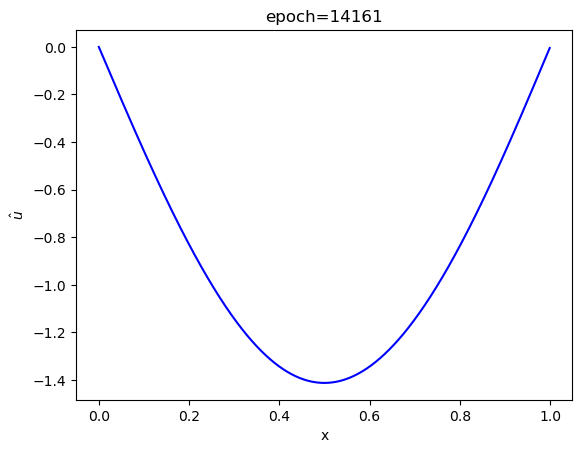


prediction normalization constant = 0.7297263921750518
min prediction = -1.4251177619721913
max prediction = 1.404773848326128
E = 9.400000000000007
predicted wavefunction:


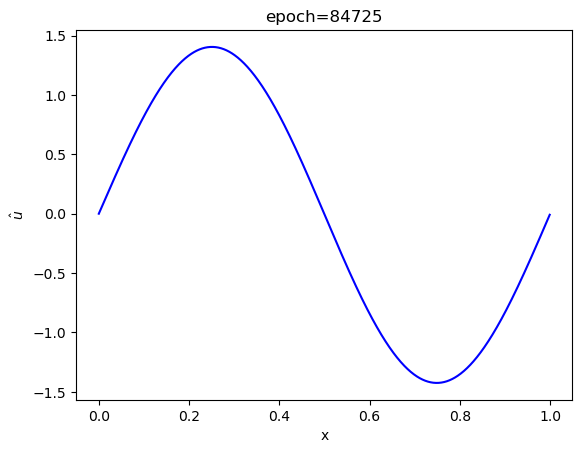


prediction normalization constant = 0.5356070824972675
min prediction = -1.4203638326272783
max prediction = 1.4063905962482488
E = 21.10000000000002
predicted wavefunction:


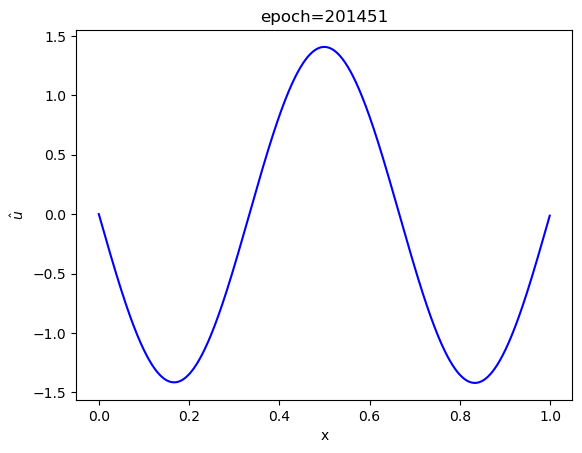

In [ ]:
min_loss_windows = [(9000, 20000), (75000, 85000), (200000, 203000)]  # NOTE hardcoded limits, could determine these in a more clever way
eigen_pinns = get_best_pinns(min_loss_windows, prev_pinns, x_test, dx, train_loss_vals, loss_criteria_idx, use_pred_norm_const=True)

### compare predictions to analytical solution

n = 1
analytical E = 2.3469919265790495
predicted E = 2.4000000000000012
differential eqn loss = 0.025504216094229922
prediction normalization constant = 0.5028211034545801
flipped sign = True

MSE = 0.0063734541184634055
orthogonal term: 0.0

predicted wavefunction:


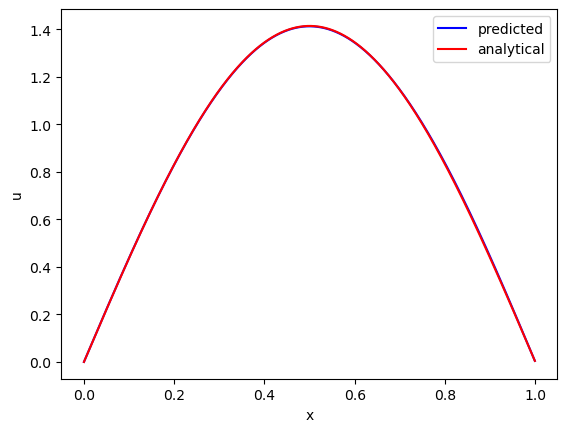


n = 2
analytical E = 9.387967706316198
predicted E = 9.400000000000007
differential eqn loss = 0.021874888638668166
prediction normalization constant = 0.7297263921750518
flipped sign = False

MSE = 0.06883464445757295
orthogonal term: -0.008657364748543894

predicted wavefunction:


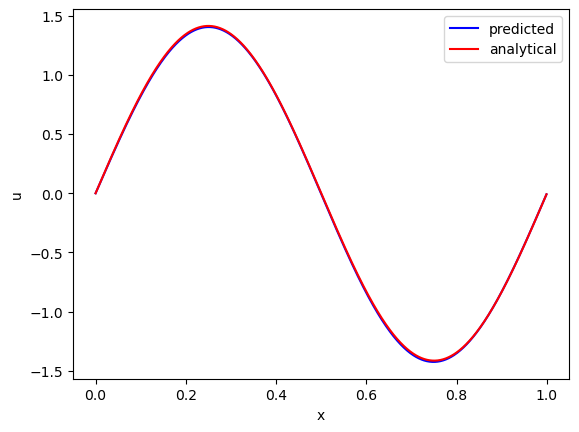


n = 3
analytical E = 21.122927339211447
predicted E = 21.10000000000002
differential eqn loss = 0.03392605408330985
prediction normalization constant = 0.5356070824972675
flipped sign = True

MSE = 0.04732250588455908
orthogonal term: 0.002888989045113915

predicted wavefunction:


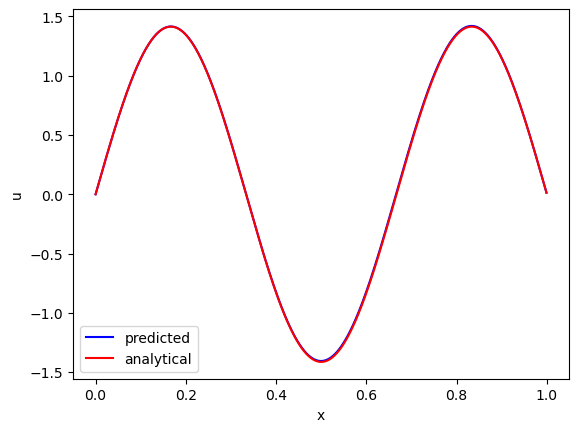

In [22]:
prev_u = np.array([0. for _ in range(x_test.shape[0])])

# look at each predicted solution against the analytical solutions
for i, eigen_pinn in enumerate(eigen_pinns):
    pred_vec = compare_analytical(eigen_pinn, i + 1, x_test, prev_u, dx, x_max)
    prev_u = prev_u + pred_vec

### EXPERIMENTAL fit polynomial between predicted E and n

In [23]:
def fit_polynomial(n, E, degree, max_n):
    # fit and print polynomial
    poly_model = np.polyfit(n, E, deg=degree)
    print(f"polynomial: E = {' + '.join([f'{poly_model[i]:.2f}n^{degree - i}' if i < degree else f'{poly_model[i]:.2f}'  for i in range(degree + 1)])}")

    # print polynomial predicted E 
    preds = np.polyval(poly_model, [i + 1 for i in range(max_n)])
    for i, pred in enumerate(preds):
        n = i + 1
        print(f"E_{n} = {pred}")

    return poly_model, preds

In [24]:
n_vals = [i + 1 for i in range(len(eigen_pinns))]
E_vals = [p["model"].E.item() for p in eigen_pinns]
degree = len(E_vals) - 1
max_n = 6
poly_E_model, poly_E_preds = fit_polynomial(n_vals, E_vals, degree, max_n)

polynomial: E = 2.35n^2 + -0.05n^1 + 0.10
E_1 = 2.4000000000000017
E_2 = 9.400000000000002
E_3 = 21.100000000000012
E_4 = 37.50000000000002
E_5 = 58.60000000000004
E_6 = 84.40000000000006


### "zoom in" on predicted E and retrain

In [25]:
# set new E ranges to search over
new_E = []

# generate ranges for E values already predicted with a smaller search width and step size
prev_E_preds = [pinn_dict["model"].E.item() for pinn_dict in eigen_pinns]
prev_E_delta = 0.2
prev_E_step = 0.01
for prev_E_pred in prev_E_preds:
    new_E.append(np.arange(prev_E_pred - prev_E_delta, prev_E_pred + prev_E_delta + prev_E_step, prev_E_step))

# generate ranges for polynomial predicted E values with a larger search width and step size
poly_E_delta = 1
poly_E_step = 0.1
for poly_E_pred in poly_E_preds[len(prev_E_preds):]:
    new_E.append(np.arange(poly_E_pred - poly_E_delta, poly_E_pred + poly_E_delta + poly_E_step, poly_E_step))

training network on E in [2.200000000000001, 85.39999999999995] with 1000 training steps per E (190000 total training steps)...


/tmp/ipykernel_9525/2910698215.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor(init_E, dtype=torch.double).to(device)


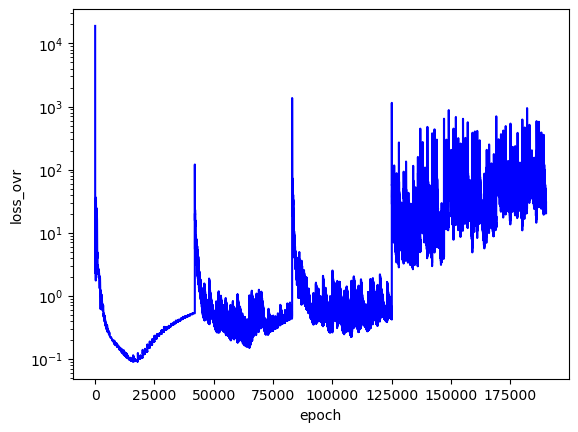

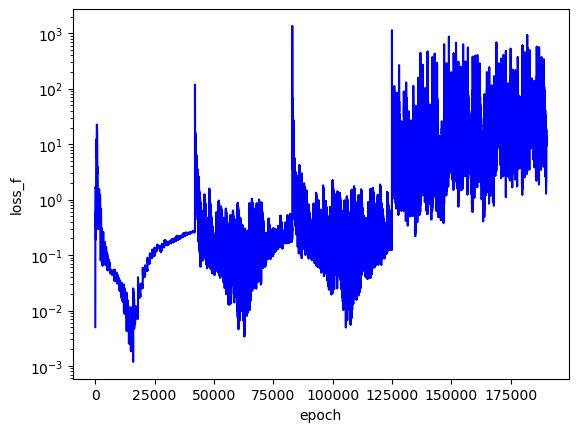

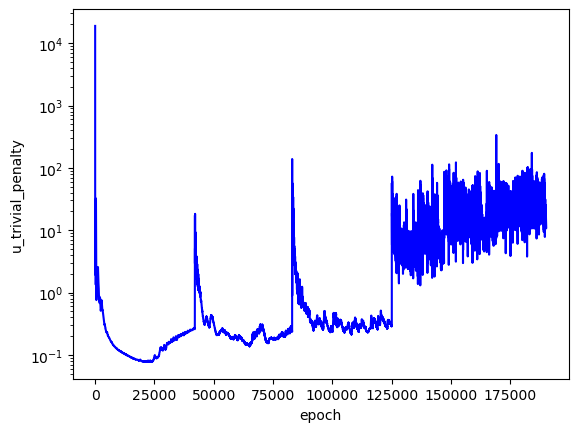

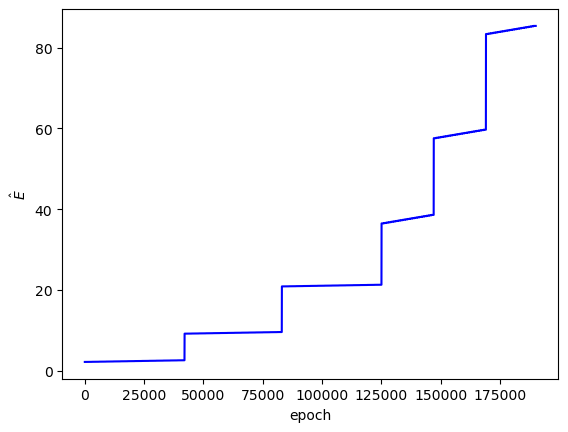

train time: 10.99 minutes
Created bash script create_progress_video_Emin=2.200_Emax=85.400.sh to generate progress video from plots. Run script from correct bash environment.


best pinns:
prediction normalization constant = 0.29675750986084176
min prediction = 0.0
max prediction = 1.4137482938722574
E = 2.349999999999998
predicted wavefunction:


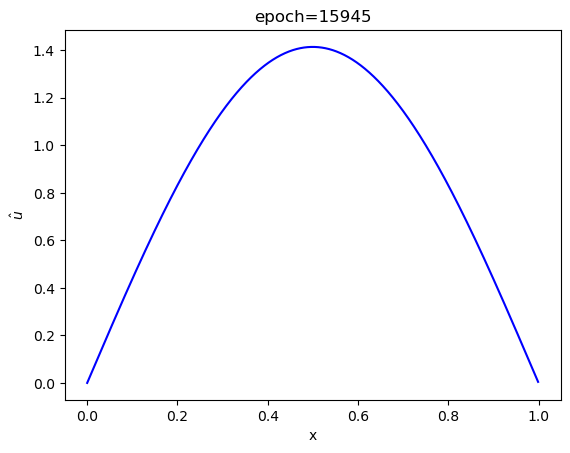


prediction normalization constant = 0.40414692723389667
min prediction = -1.412664981496508
max prediction = 1.415617539888483
E = 9.400000000000004
predicted wavefunction:


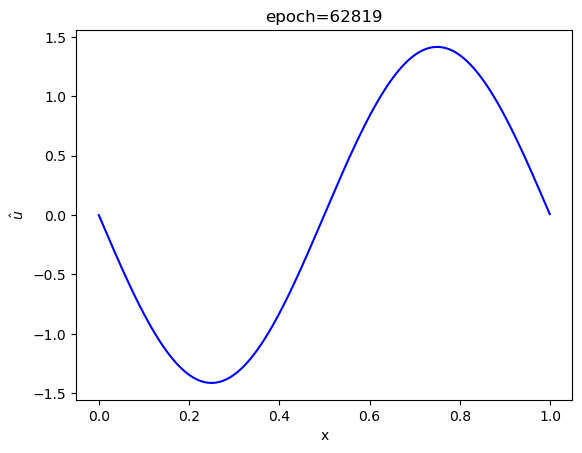


prediction normalization constant = 0.5215444155571322
min prediction = -1.4221517097043757
max prediction = 1.4116927276293645
E = 21.120000000000054
predicted wavefunction:


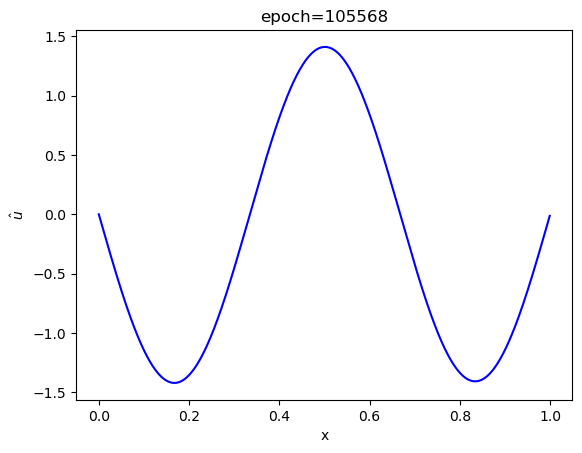


prediction normalization constant = 2.2157146059465087
min prediction = -1.4359032350384298
max prediction = 1.4437457485376852
E = 37.400000000000034
predicted wavefunction:


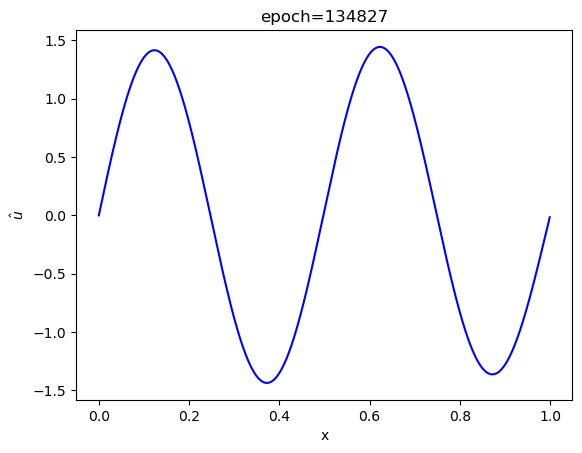


prediction normalization constant = 3.309842600019941
min prediction = -1.4402277460441397
max prediction = 1.4222813550581255
E = 59.20000000000006
predicted wavefunction:


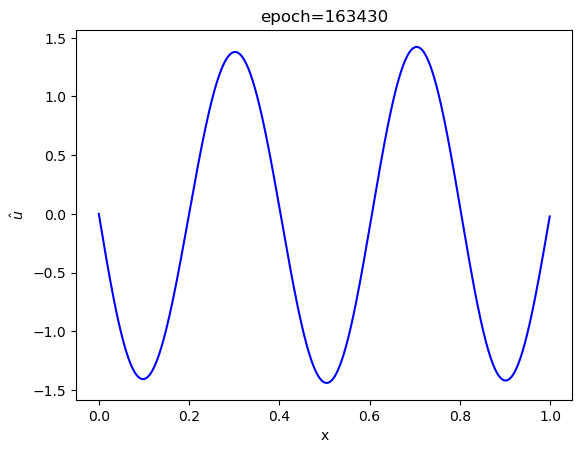


prediction normalization constant = 4.23405652626445
min prediction = -1.550836610894533
max prediction = 1.416063370535164
E = 83.70000000000005
predicted wavefunction:


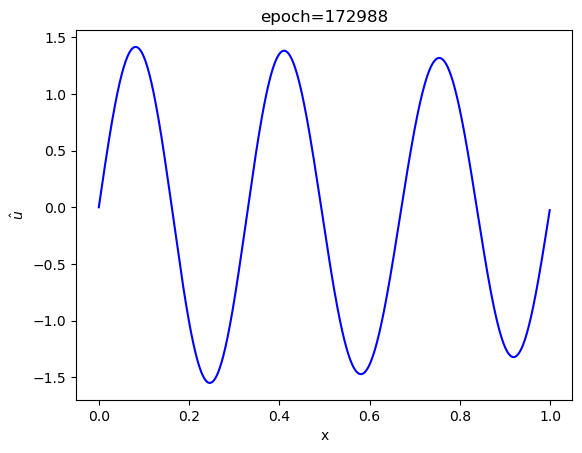

In [26]:
num_train_steps_per_E = 1000
save_denom = num_train_steps_per_E
loss_criteria_idx = 1
train_model_per_E = False  # set to True to train a single model from scratch for each E range

if (train_model_per_E):
    new_eigen_pinns = []
    
    for E_range in new_E:
        print("=" * 100)
        pinns, loss_vals, total_epochs = run_train_loop(x_train, 
                                                        x_min, 
                                                        x_max, 
                                                        perturb_sig, 
                                                        E_range, 
                                                        num_train_steps_per_E, 
                                                        save_denom,
                                                        "", 
                                                        loss_criteria_idx, 
                                                        device, 
                                                        print_epoch_status=False,
                                                        save_models=False)
        zoom_windows = [(100, total_epochs)]  # assumes first few epochs may be trivial and only want one solution per E
        new_eigen_pinns.append(get_best_pinns(zoom_windows, pinns, x_test, dx, loss_vals, loss_criteria_idx, use_pred_norm_const=True)[0])
        print("=" * 100)
else:
    # track the size of each sub array of E values to index for tracking of current analytical soln in train loop call
    idx_sum = 0
    new_E_max_indexes = []
    for sub_E in new_E:
        new_E_max_indexes.append(sub_E.shape[0] + idx_sum)
        idx_sum += sub_E.shape[0]

    # reshape each E range into one array
    new_E_flattened = [val for sub_E in new_E for val in sub_E]
        
    # train models
    pinns, loss_vals, total_epochs = run_train_loop(x_train, 
                                                    x_min, 
                                                    x_max, 
                                                    perturb_sig, 
                                                    new_E_flattened, 
                                                    num_train_steps_per_E, 
                                                    save_denom,
                                                    "", 
                                                    loss_criteria_idx, 
                                                    device, 
                                                    print_epoch_status=False,
                                                    save_models=False,
                                                    save_progress_vid=True,
                                                    save_progress_dir="post_scan_E_ranges_progress_plots",
                                                    E_range_idx_per_n=new_E_max_indexes)
        
    # assumes first few epochs may be trivial and only want one solution per E
    # identify best pinns across each new E range
    zoom_windows = []
    start_idx = 100
    for idx in new_E_max_indexes:
        zoom_windows.append((start_idx, idx * num_train_steps_per_E))
        start_idx = idx * num_train_steps_per_E
    
    print(f"\nbest pinns:")
    new_eigen_pinns = get_best_pinns(zoom_windows, pinns, x_test, dx, loss_vals, loss_criteria_idx, use_pred_norm_const=True)

n = 1
analytical E = 2.3469919265790495
predicted E = 2.349999999999998
differential eqn loss = 0.0011814092306512722
prediction normalization constant = 0.29675750986084176
flipped sign = False

MSE = 0.0001063434491498261
orthogonal term: 0.0

predicted wavefunction:


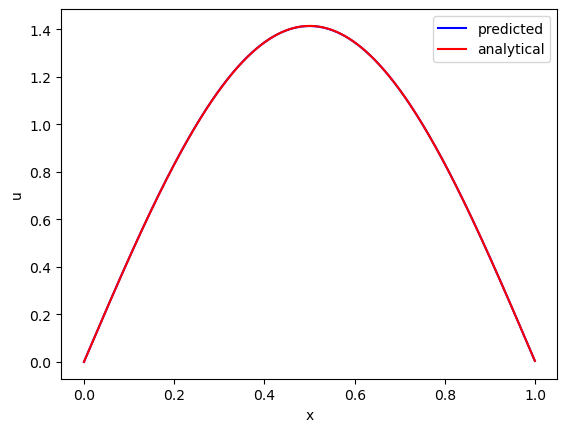


n = 2
analytical E = 9.387967706316198
predicted E = 9.400000000000004
differential eqn loss = 0.0033840861939831448
prediction normalization constant = 0.40414692723389667
flipped sign = True

MSE = 0.007909024675933084
orthogonal term: -0.0023006735989656397

predicted wavefunction:


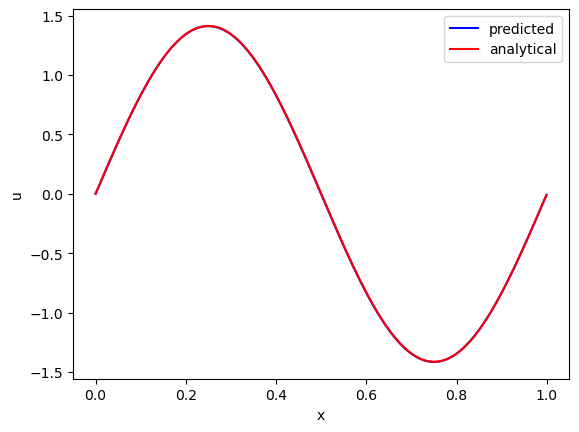


n = 3
analytical E = 21.122927339211447
predicted E = 21.120000000000054
differential eqn loss = 0.004924387229954937
prediction normalization constant = 0.5215444155571322
flipped sign = True

MSE = 0.09777751423888642
orthogonal term: 0.012284722515263783

predicted wavefunction:


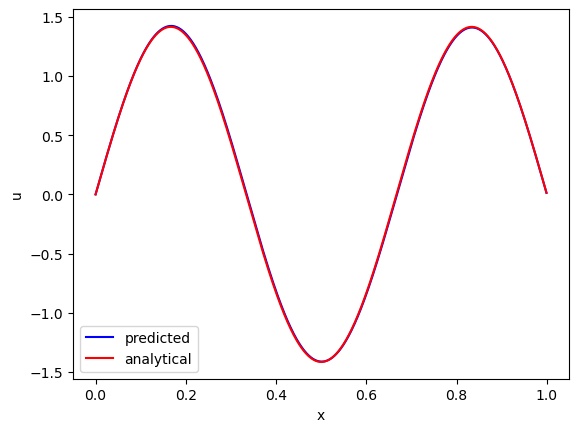


n = 4
analytical E = 37.55187082526479
predicted E = 37.400000000000034
differential eqn loss = 0.21915562916174913
prediction normalization constant = 2.2157146059465087
flipped sign = False

MSE = 1.2361811981252755
orthogonal term: -0.02537807493618969

predicted wavefunction:


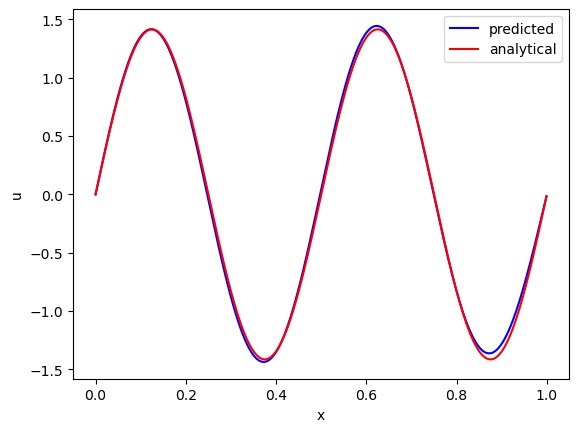


n = 5
analytical E = 58.674798164476236
predicted E = 59.20000000000006
differential eqn loss = 0.40505068203675954
prediction normalization constant = 3.309842600019941
flipped sign = True

MSE = 2.3650612952122847
orthogonal term: 0.04323865780329224

predicted wavefunction:


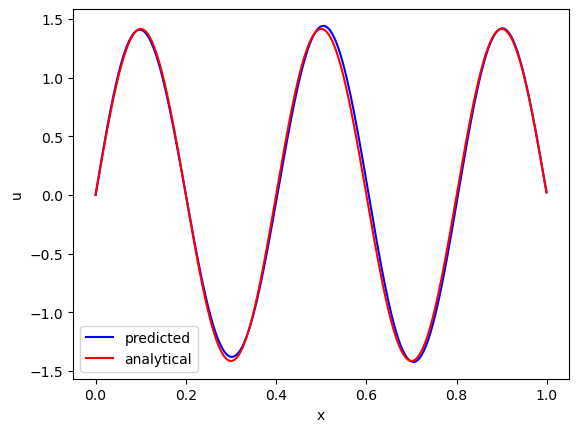


n = 6
analytical E = 84.49170935684579
predicted E = 83.70000000000005
differential eqn loss = 1.1076638266648338
prediction normalization constant = 4.23405652626445
flipped sign = False

MSE = 10.36527536322582
orthogonal term: -0.1473003073551689

predicted wavefunction:


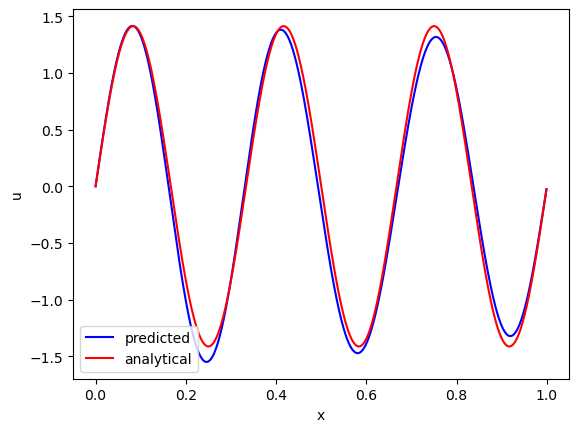

In [27]:
new_prev_u = np.array([0. for _ in range(x_test.shape[0])])

for i, new_eigen_pinn in enumerate(new_eigen_pinns):
    n = i + 1
    new_pred_vec = compare_analytical(new_eigen_pinn, n, x_test, new_prev_u, dx, x_max)
    new_prev_u = new_prev_u + new_pred_vec

### repeat process of setting E ranges and retraining models above until satisfied...